In [1]:
import numpy as np
import numpy.ma as ma

import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import ticker

from scipy import signal, spatial
from scipy.spatial.distance import pdist,cdist, squareform
from sklearn.feature_extraction import image
import itertools
import random
from scipy import signal

# After installing new version of numpy we have warnings.
# If you want to remove them simply uncomment these 2 lines.
from warnings import simplefilter
simplefilter(action='ignore', category=DeprecationWarning)

Local dimension and stability for daily suface temperature (i.e., temperaturee at 2 meters) in the tropical Pacific. Main code for computation of the metrics has been downloaded from Yoann Robin repository https://github.com/yrobink/CDSK/tree/master/python/CDSK . Thanks Yoann!

We look at temperature at the surface (at 2 m) from from 1979 to 2019. We have daily time steps and Seasonal cycle and trends have been removed. 

(The dataset with temperature is too large to be uploaded on github.)

## Some functions

In [2]:
import netCDF4
from netCDF4 import Dataset
def importNetcdf(path,variable_name):
    nc_fid = Dataset(path, 'r')
    field = nc_fid.variables[variable_name][:]     
    return field 

def masked_array_to_numpy(data):
    return np.ma.filled(data.astype(np.float32), np.nan);

## Loading the data

In [3]:
# Load data
# Standardize to zero mean and unit variance
path = './ERA5_Pacific_anomalies.nc'

In [4]:
lat = importNetcdf(path,'latitude')
lat = masked_array_to_numpy(lat)

lon = importNetcdf(path,'longitude')
lon = masked_array_to_numpy(lon)

# Transform latitudes in radians
latitudes = np.radians(lat);
# Assign a weight to each latitude phi
lat_weights = np.cos(latitudes).reshape(len(latitudes),1)

In [5]:
# We want just the Ocean and not the land
path_ocean = './sst_1day_1990.nc'
# Temperature
sst = importNetcdf(path_ocean,'sst')
sst = masked_array_to_numpy(sst)
land = sst[0]
land[~np.isnan(land)]=0

In [6]:
############################ Temperature

# Load
data = importNetcdf(path,'t2m') # t2m is the temperature at 2 meters
data = masked_array_to_numpy(data)

# mask the land
data = data + land

# Weight with cosine of latitude
data = data * lat_weights

# Standardize it to zero mean and unit variance is important when using more than 1 variable
# This is not the case here but it does not hurt doing it

# Remove mean from each time series
data = data - np.nanmean(data)

# Standardize 
data = data/np.nanstd(data)

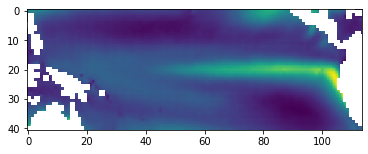

In [7]:
# Let's check the standard deviation

plt.imshow(np.std(data,axis = 0))

## Embed data

In [8]:
# Dimensions of each field
dim_lon = np.shape(data)[2] # Points in Y axis
dim_lat = np.shape(data)[1] # Points in X axis
dim_t = np.shape(data)[0]

data_reshaped = data.reshape(dim_t,dim_lat*dim_lon)
np.shape(data_reshaped)

(14975, 4674)

In [9]:
# consider only data that are not nans

data_embed = []

for i in range(np.shape(data_reshaped)[1]):
    if ~np.isnan(data_reshaped[0,i]):
       data_embed.append(data_reshaped[:,i])
data_embed = np.transpose(np.array(data_embed))

In [10]:
# we have 14975 days in a 4674th dimensional state space

np.shape(data_embed)

(14975, 4273)

## Dynamical systems metrics

In [11]:
from metrics import *

In [12]:
print('Computing local dimension and theta')
X = data_embed
localDim,theta = indicators( X , Y = None , metric = "euclidean" , q = 0.97 , n_jobs = 1 , pareto_fit = "scipy" , theta_fit = "sueveges" , distXY = None )

Computing local dimension and theta


In [13]:
# Save the results
np.save('./localDim_no_season_no_trend.npy',localDim)
np.save('./theta_no_season_no_trend.npy',theta)

In [14]:
# Dimensionality of the inertial manifold
np.mean(localDim)

37.11670037953643

## Plot time series of local dimension and persistence

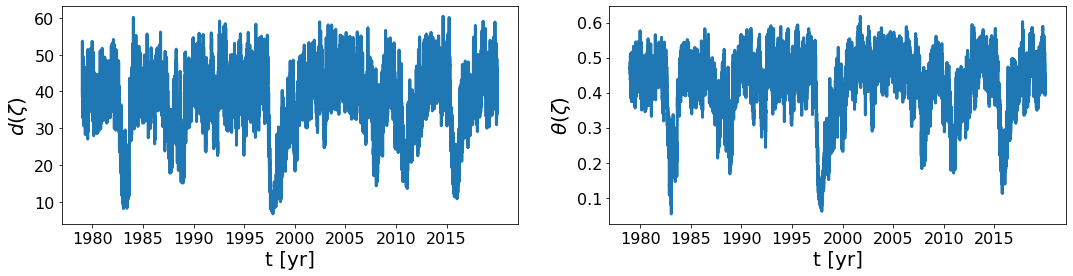

In [15]:
fig = plt.figure(figsize=(18,4))

ax = fig.add_subplot(121)

ax.plot(localDim,linewidth = 3)
plt.xlabel('t [yr]',fontsize = 20)
plt.ylabel('$d(\zeta)$',fontsize = 20)
#plt.ylim(20,60)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
#ax.text(1, 0.1, 'No Seasonality, No Linear trend', fontsize=16)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
ax.set_xticks([365,2190,4015,5840,7665,9490,11315,13140])
ax.set_xticklabels(['1980','1985','1990','1995','2000','2005','2010','2015'])

plt.subplots_adjust(wspace=0, hspace=0.1)

ax = fig.add_subplot(122)

ax.plot(theta,linewidth = 3)
plt.xlabel('t [yr]',fontsize = 20)
plt.ylabel(r'${\theta(\zeta)}$',fontsize = 20)
#plt.ylim(20,60)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
#ax.text(1, 0.1, 'No Seasonality, No Linear trend', fontsize=16)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
ax.set_xticks([365,2190,4015,5840,7665,9490,11315,13140])
ax.set_xticklabels(['1980','1985','1990','1995','2000','2005','2010','2015'])

plt.subplots_adjust(wspace=0.2, hspace=0.1)


plt.show()

fig.savefig('./local_dim_and_stability.png',bbox_inches='tight') 